In [1]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from tensorflow.keras.layers import Flatten, Dense, Dropout,BatchNormalization
from tensorflow.keras.layers import Input, concatenate
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers
import tensorflow.keras.metrics as metric
import os

## 定義變數數集

In [10]:
NB_CLASS=9
LEARNING_RATE=0.01
MOMENTUM=0.9
DROPOUT=0.4
WEIGHT_DECAY=0.0005
LRN2D_NORM=True
DATA_FORMAT='channels_last' # Theano:'channels_first' Tensorflow:'channels_last'
USE_BN=True
IM_WIDTH=114
IM_HEIGHT=114
batch_size=400
EPOCH= 1

train_root= r'C:\Users\morri\OneDrive\桌面\naruto-handsigns-predict-dl-master\datasetTrain'
vaildation_root= r'C:\Users\morri\OneDrive\桌面\naruto-handsigns-predict-dl-master\datasetTrain'
test_root= r'C:\Users\morri\OneDrive\桌面\naruto-handsigns-predict-dl-master\datasetTest'

## 訓練生成器 測試生成器

In [7]:
#train data
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    featurewise_center=True
)
train_generator = train_datagen.flow_from_directory(
  train_root,
  target_size=(IM_WIDTH, IM_HEIGHT),
  batch_size=batch_size,
)

#vaild data
vaild_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    featurewise_center=True
)
vaild_generator = train_datagen.flow_from_directory(
  vaildation_root,
  target_size=(IM_WIDTH, IM_HEIGHT),
  batch_size=batch_size,
)

#test data
test_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    featurewise_center=True
)
test_generator = train_datagen.flow_from_directory(
  test_root,
  target_size=(IM_WIDTH, IM_HEIGHT),
  batch_size=batch_size,
)

Found 6223 images belonging to 9 classes.
Found 6223 images belonging to 9 classes.
Found 780 images belonging to 8 classes.


## 定義函數學習機

In [8]:
#normalization
def conv2D_lrn2d(x,filters,kernel_size,strides=(1,1),padding='same',data_format=DATA_FORMAT,dilation_rate=(1,1),activation='relu',use_bias=True,kernel_initializer='glorot_uniform',bias_initializer='zeros',kernel_regularizer=None,bias_regularizer=None,activity_regularizer=None,kernel_constraint=None,bias_constraint=None,lrn2d_norm=LRN2D_NORM,weight_decay=WEIGHT_DECAY):
    #l2 normalization
    if weight_decay:
        kernel_regularizer=regularizers.l2(weight_decay)
        bias_regularizer=regularizers.l2(weight_decay)
    else:
        kernel_regularizer=None
        bias_regularizer=None

    x=Conv2D(filters=filters,kernel_size=kernel_size,strides=strides,padding=padding,data_format=data_format,dilation_rate=dilation_rate,activation=activation,use_bias=use_bias,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(x)

    if lrn2d_norm:
        #batch normalization
        x=BatchNormalization()(x)

    return x


def inception_module(x,params,concat_axis,padding='same',data_format=DATA_FORMAT,dilation_rate=(1,1),activation='relu',use_bias=True,kernel_initializer='glorot_uniform',bias_initializer='zeros',kernel_regularizer=None,bias_regularizer=None,activity_regularizer=None,kernel_constraint=None,bias_constraint=None,lrn2d_norm=LRN2D_NORM,weight_decay=None):
    (branch1,branch2,branch3,branch4)=params
    if weight_decay:
        kernel_regularizer=regularizers.l2(weight_decay)
        bias_regularizer=regularizers.l2(weight_decay)
    else:
        kernel_regularizer=None
        bias_regularizer=None
    #1x1
    pathway1=Conv2D(filters=branch1[0],kernel_size=(1,1),strides=1,padding=padding,data_format=data_format,dilation_rate=dilation_rate,activation=activation,use_bias=use_bias,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(x)

    #1x1->3x3
    pathway2=Conv2D(filters=branch2[0],kernel_size=(1,1),strides=1,padding=padding,data_format=data_format,dilation_rate=dilation_rate,activation=activation,use_bias=use_bias,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(x)
    pathway2=Conv2D(filters=branch2[1],kernel_size=(3,3),strides=1,padding=padding,data_format=data_format,dilation_rate=dilation_rate,activation=activation,use_bias=use_bias,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(pathway2)

    #1x1->5x5
    pathway3=Conv2D(filters=branch3[0],kernel_size=(1,1),strides=1,padding=padding,data_format=data_format,dilation_rate=dilation_rate,activation=activation,use_bias=use_bias,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(x)
    pathway3=Conv2D(filters=branch3[1],kernel_size=(5,5),strides=1,padding=padding,data_format=data_format,dilation_rate=dilation_rate,activation=activation,use_bias=use_bias,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(pathway3)

    #3x3->1x1
    pathway4=MaxPooling2D(pool_size=(3,3),strides=1,padding=padding,data_format=DATA_FORMAT)(x)
    pathway4=Conv2D(filters=branch4[0],kernel_size=(1,1),strides=1,padding=padding,data_format=data_format,dilation_rate=dilation_rate,activation=activation,use_bias=use_bias,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(pathway4)

    return concatenate([pathway1,pathway2,pathway3,pathway4],axis=concat_axis)

def create_model():
    #Data format:tensorflow,channels_last;theano,channels_last
    if DATA_FORMAT=='channels_first':
        INP_SHAPE=(3,114,114)
        img_input=Input(shape=INP_SHAPE)
        CONCAT_AXIS=1
    elif DATA_FORMAT=='channels_last':
        INP_SHAPE=(114,114,3)
        img_input=Input(shape=INP_SHAPE)
        CONCAT_AXIS=3
    else:
        raise Exception('Invalid Dim Ordering')

    x=conv2D_lrn2d(img_input,64,(5,5),2,padding='same',lrn2d_norm=False)
    x=MaxPooling2D(pool_size=(3,3),strides=2,padding='same',data_format=DATA_FORMAT)(x)
    x=BatchNormalization()(x)

    x=conv2D_lrn2d(x,64,(1,1),1,padding='same',lrn2d_norm=False)

    x=conv2D_lrn2d(x,192,(3,3),1,padding='same',lrn2d_norm=True)
    x=MaxPooling2D(pool_size=(3,3),strides=2,padding='same',data_format=DATA_FORMAT)(x)

    x=inception_module(x,params=[(64,),(96,128),(16,32),(32,)],concat_axis=CONCAT_AXIS) #3a
    x=inception_module(x,params=[(128,),(128,192),(32,96),(64,)],concat_axis=CONCAT_AXIS) #3b
    x=MaxPooling2D(pool_size=(3,3),strides=2,padding='same',data_format=DATA_FORMAT)(x)

    
    ### 為了讓訓練的速度增加 將兩層數收起來
    
    #x=inception_module(x,params=[(192,),(96,208),(16,48),(64,)],concat_axis=CONCAT_AXIS) #4a
    #x=inception_module(x,params=[(160,),(112,224),(24,64),(64,)],concat_axis=CONCAT_AXIS) #4b
    #x=inception_module(x,params=[(128,),(128,256),(24,64),(64,)],concat_axis=CONCAT_AXIS) #4c
    #x=inception_module(x,params=[(112,),(144,288),(32,64),(64,)],concat_axis=CONCAT_AXIS) #4d
    #x=inception_module(x,params=[(256,),(160,320),(32,128),(128,)],concat_axis=CONCAT_AXIS) #4e
    #x=MaxPooling2D(pool_size=(3,3),strides=2,padding='same',data_format=DATA_FORMAT)(x)

    #x=inception_module(x,params=[(256,),(160,320),(32,128),(128,)],concat_axis=CONCAT_AXIS) #5a
    #x=inception_module(x,params=[(384,),(192,384),(48,128),(128,)],concat_axis=CONCAT_AXIS) #5b
    #x=AveragePooling2D(pool_size=(7,7),strides=1,padding='valid',data_format=DATA_FORMAT)(x)

    x=Flatten()(x)
    x=Dropout(DROPOUT)(x)
    x=Dense(NB_CLASS,activation='linear')(x)
    x=Dense(NB_CLASS,activation='softmax')(x)

    return x,img_input,CONCAT_AXIS,INP_SHAPE,DATA_FORMAT


def check_print():
    # Create the Model
    x,img_input,CONCAT_AXIS,INP_SHAPE,DATA_FORMAT=create_model()

    # Create a Keras Model
    model=Model(inputs=img_input,outputs=[x])
    model.summary()

    # Save a PNG of the Model Build
    # plot_model(model,to_file='GoogLeNet.png',show_shapes=True)

    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc',metric.top_k_categorical_accuracy])
    return model

In [11]:
if __name__=='__main__':
    if os.path.exists('inception_1.h5'):
        model=load_model('inception_1.h5')
    else:
        model=check_print()

    history = model.fit_generator(train_generator,validation_data=vaild_generator,epochs=EPOCH,steps_per_epoch=train_generator.n/batch_size
                        ,validation_steps=vaild_generator.n/batch_size)
    model.save('inception_1.h5')
   ## model.metrics=['acc',metric.top_k_categorical_accuracy]
    ## loss,acc,top_acc=model.evaluate_generator(test_generator,steps=test_generator.n/batch_size)

C:\Users\morri\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 15.5575 steps, validate for 15.5575 steps


C:\Users\morri\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


16/15 [==============================] - 337s 21s/step - loss: 0.0464 - acc: 0.9990 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.0468 - val_acc: 0.9994 - val_top_k_categorical_accuracy: 1.0000


In [14]:
history.history

{'loss': [0.046528671387593194],
 'acc': [0.99903584],
 'top_k_categorical_accuracy': [1.0],
 'val_loss': [0.046842162026367484],
 'val_acc': [0.9993572],
 'val_top_k_categorical_accuracy': [1.0]}

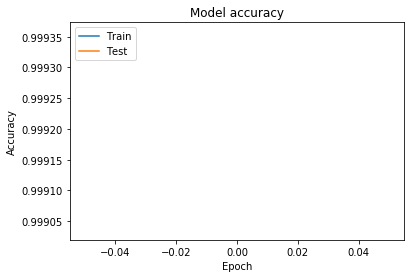

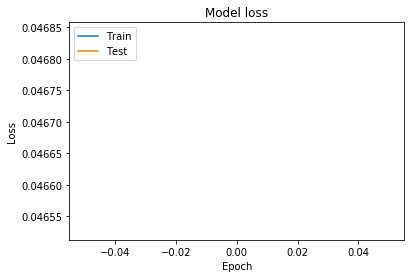

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [17]:
import json
model_json = model.to_json()
with open("model_in_json.json", "w") as json_file:
    json.dump(model_json, json_file)

model.save_weights('model_weights.h5')

In [18]:
import numpy as np
import operator
import cv2
import sys, os
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
import json
from PIL import Image
import pygame

pygame.init()
screen = pygame.display.set_mode((900,900),pygame.RESIZABLE)

CLIP_X1 = 160
CLIP_Y1 = 140
CLIP_X2 = 400
CLIP_Y2 = 360

with open('model_in_json.json','r') as f:
    model_json = json.load(f)
loaded_model = model_from_json(model_json)
loaded_model.load_weights('model_weights.h5')

cap = cv2.VideoCapture(0)

while True:
    _, FrameImage = cap.read()
    FrameImage = cv2.flip(FrameImage, 1)
    cv2.imshow("", FrameImage)
    cv2.rectangle(FrameImage, (CLIP_X1, CLIP_Y1), (CLIP_X2, CLIP_Y2), (0,255,0) ,1)

    ROI = FrameImage[CLIP_Y1:CLIP_Y2, CLIP_X1:CLIP_X2]
    ROI = cv2.resize(ROI, (64, 64)) 
    ROI = cv2.cvtColor(ROI, cv2.COLOR_BGR2GRAY)
    #ROI= cv2.add(ROI,np.array([40.0]))
    _, output = cv2.threshold(ROI, 100, 255, cv2.THRESH_BINARY) # adjust brightness
    
    SHOWROI = cv2.resize(ROI, (256, 256)) 
    _, output2 = cv2.threshold(SHOWROI, 100, 255, cv2.THRESH_BINARY)
    cv2.imshow("ROI", output2)
    
    result = loaded_model.predict(output.reshape(1, 64, 64, 1))
    predict =   { 'bird':    result[0][0],
                  'dragon':    result[0][1],    
                  'horse':    result[0][2],
                  'monkey':    result[0][3],
                  'dog':    result[0][3],
                  'ox':    result[0][5],
                  'serpent':    result[0][6],
                  'ram':    result[0][7],
                  }
    
    predict = sorted(predict.items(), key=operator.itemgetter(1), reverse=True)
    
    if(predict[0][1] == 1.0):
        predict_img  = pygame.image.load(os.getcwd() + '/dataset/images/' + predict[0][0] + '.png')
    else:
        predict_img  = pygame.image.load(os.getcwd() + '/dataset/images/nosign.png')
    predict_img = pygame.transform.scale(predict_img, (900, 900))
    screen.blit(predict_img, (0,0))
    pygame.display.flip()
    interrupt = cv2.waitKey(10)

    if interrupt & 0xFF == ord('q'): # esc key
        break
            
pygame.quit()
cap.release()
cv2.destroyAllWindows()

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


error: OpenCV(4.2.0) C:\projects\opencv-python\opencv\modules\highgui\src\window.cpp:376: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'cv::imshow'
